In [5]:
from IPython.display import display
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import matthews_corrcoef, f1_score
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({"font.size": 15, 
                            "font.family": "STIXGeneral",
                            "mathtext.fontset": "cm"})

In [3]:
glue_tasks = ["CoLA", "SST-2", "Sara"]
metrics = {
    "CoLA": "MCC",
    "SST-2": "accuracy",
    "Sara": "micro-avg F1"
}
model_types = {
    "main": ["teacher", "BERT", "LSTM"],
    "additional": ["scratch", "hard-logits"]
}
model_type_bar_hatches = {
    "main": "",
    "scratch": "//",
    "hard-logits": "x"
#     ('-', '+', 'x', '\\', '*', 'o', 'O', '.')
}
model_colours = { # http://mkweb.bcgsc.ca/colorblind/
    "teacher": (150, 75, 0), # brown (0, 0, 0), # black
    "LSTM": (86, 180, 233), # sky blue
    "BERT": (230, 159, 0), # orange
    "embedding": (0, 114, 178) # blue
}
model_colours = {name: np.array(c)/255 for name, c in model_colours.items()}

best_model_scores = {
    "CoLA": {
        "teacher": 59.9,
        "BERT": 45.0,
        "BERT-scratch": 35.2,
        "BERT-hard-logits": 37.3,
        "LSTM": 44.2, # 44.8
        "LSTM-scratch": 37.5,
        "LSTM-hard-logits": 38.4
    },
    "SST-2": {
        "teacher": 91.5,
        "BERT": 89.3, # 89.2
        "BERT-scratch": 87.4,
        "BERT-hard-logits": 86.7,
        "LSTM": 91.2, # 91.9
        "LSTM-scratch": 90.8,
        "LSTM-hard-logits": 90.6
    },
    "Sara": {
        "teacher": 87.5,
        "BERT": 87.1,
        "BERT-scratch": 86.0,
        "BERT-hard-logits": 84.1,
        "LSTM": 86.5,
        "LSTM-scratch": 85.6,
        "LSTM-hard-logits": 84.9
    },
}

with open("predictions/eval_prediction_entropies.pkl", 'rb') as handle:
    eval_prediction_entropies = pickle.load(handle)

def simple_accuracy(preds, labels):
    return (np.reshape(preds, (-1,)) == np.reshape(labels, (-1,))).mean()
    
def compute_score(preds, labels, task):
    if task == "CoLA":
        return matthews_corrcoef(labels, preds)
    elif task == "Sara":
        return f1_score(y_true=labels, y_pred=preds, average="micro")
    elif task == "SST-2":
        return simple_accuracy(preds, labels)
    else:
        raise KeyError(task)

# Comparing performance of best models

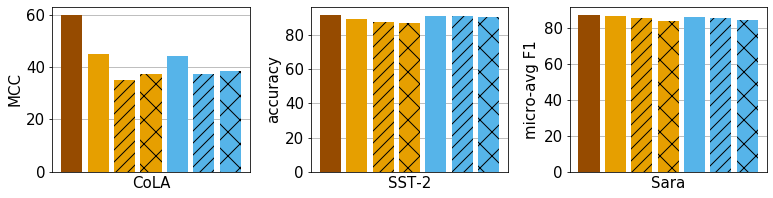

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 3))
for ax, task in zip(axs, glue_tasks):
    results = [best_model_scores[task]["teacher"]]
    colours = [model_colours["teacher"]]
    hatches = [model_type_bar_hatches["main"]]
    for main_model_type in ["BERT", "LSTM"]:
        all_model_types = [main_model_type] + [(main_model_type + "-" + additional) for additional in model_types["additional"]]
        colours += [model_colours[main_model_type] for _ in range(len(model_types["additional"])+1)]
        hatches += [model_type_bar_hatches[model_type] for model_type in (["main"] + model_types["additional"])]
        for model_type in all_model_types:
            results.append(best_model_scores[task][model_type])
    ax.bar(range(len(results)), results, color=colours)
    for bar, hatch in zip(ax.patches, hatches): bar.set_hatch(hatch)
    ax.set_ylabel(metrics[task])
    ax.set_xlabel(task)
    ax.tick_params(axis="x", labelbottom=False, length=0)
    ax.grid(axis="y")
    ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

# Comparing best models' eval-set prediction entropy

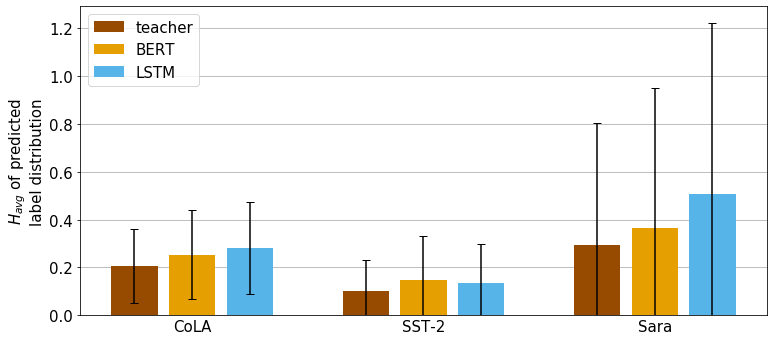

In [12]:
fig = plt.figure(figsize=(11, 5))
ax = plt.gca()
for i, task in enumerate(glue_tasks):
    for j, model_type in enumerate(model_types["main"]):
        ax.bar(j+i*(1+len(model_types["main"])), 
               eval_prediction_entropies[task][model_type]["mean"], 
               color=model_colours[model_type],
               label=(model_type if i == 0 else None),
               yerr=eval_prediction_entropies[task][model_type]["std"], capsize=4)
ax.legend(loc=2)
ax.set_xticks([(1 + i*(1+len(model_types["main"]))) for i in range(3)])
ax.set_ylim(bottom=0)
ax.set_xticklabels(glue_tasks)
ax.tick_params(axis="x", length=0)
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.set_ylabel("$H_{avg}$ of predicted\nlabel distribution")
plt.tight_layout()
plt.show()

# Comparing best models' eval-set prediction average confidence

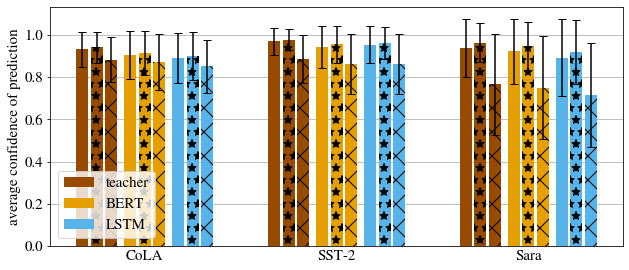

In [5]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()
for i, task in enumerate(glue_tasks):
    for j, model_type in enumerate(model_types["main"]):
        data = pd.read_csv("predictions/dev_scored_{}_{}.tsv".format(task, model_type), delimiter="\t")
        confidence = data["certainty_of_pred"].mean()
        confidence_hits = data[data["label"] == data["pred"]]["certainty_of_pred"].mean()
        confidence_misses = data[data["label"] != data["pred"]]["certainty_of_pred"].mean()
        confidence_std = data["certainty_of_pred"].std()
        confidence_hits_std = data[data["label"] == data["pred"]]["certainty_of_pred"].std()
        confidence_misses_std = data[data["label"] != data["pred"]]["certainty_of_pred"].std()
        w = 0.25
        gap = 0.05
        capsize = 4
        ax.bar(j+i*(1+len(model_types["main"]))-w-gap,
               confidence, width=w,
               color=model_colours[model_type],
               label=(model_type if i == 0 else None),
               yerr=confidence_std, capsize=capsize)
        ax.bar(j+i*(1+len(model_types["main"])),
               confidence_hits, hatch="*", width=w,
               color=model_colours[model_type],
               yerr=confidence_hits_std, capsize=capsize)
        ax.bar(j+i*(1+len(model_types["main"]))+w+gap,
               confidence_misses, hatch="x", width=w,
               color=model_colours[model_type],
               yerr=confidence_misses_std, capsize=capsize)
ax.legend(loc=3)
ax.set_xticks([(1 + i*(1+len(model_types["main"]))) for i in range(3)])
ax.set_ylim(bottom=0)
ax.set_xticklabels(glue_tasks)
ax.tick_params(axis="x", length=0)
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.set_ylabel("average confidence of prediction")
plt.tight_layout()
plt.show()

# Comparing best models' eval-set prediction confidence distributions

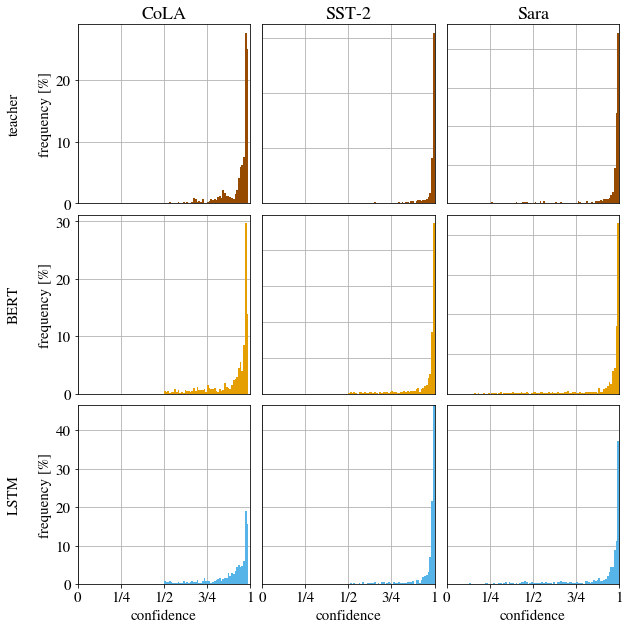

In [138]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 9), sharex="col", sharey=False)

for i, task in enumerate(glue_tasks):
    axs[0, i].set_title(task)
    max_heights = []
    for j, model_type in enumerate(model_types["main"]):        
        data = pd.read_csv("predictions/dev_scored_{}_{}.tsv".format(task, model_type), delimiter="\t")
        confidences = data["certainty_of_pred"]
        ax = axs[j, i]
        rects, bins, patches = ax.hist(confidences, bins=100, range=(0,1), color=model_colours[model_type], 
                        label=model_type, log=False, density=True)
        ax.set_xlim(0, 1.0)
        if i > 0:
            ax.tick_params(axis="y", length=0, labelleft=False)
        else:
            axs[j, 0].set_ylabel(model_type + "\n\nfrequency [%]")
        if j < 2:
            ax.tick_params(axis="x", length=0)
        else:
            ax.set_xlabel("confidence")
        
        max_height = max(rects)
        max_heights.append(max_height)
#         ax.legend(loc=2)
        ax.grid(axis="y", which="both")
        ax.grid(axis="x", which="both")
        ax.set_axisbelow(True)
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1.])
        ax.set_xticklabels(["0", "1/4", "1/2", "3/4", "1"])
    for k, _ in enumerate(model_types["main"]):
        axs[j, k].set_ylim(0, max(max_heights)*1.05)
plt.tight_layout(w_pad=0.3, h_pad=0.2)
plt.show()

# Correlation of models' confidences

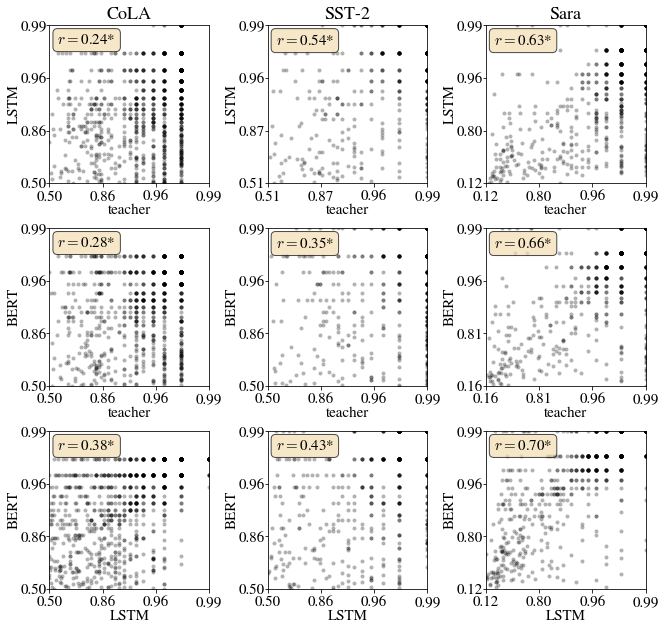

In [7]:
take_log = True
prob_log_limit = 0.99
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9.5, 9), sharex=False, sharey=False)
pairs = [("teacher", "LSTM"), ("teacher", "BERT"), ("LSTM", "BERT")]
c = [0.0]*3 + [0.3]
for i, task in enumerate(glue_tasks):
    data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
    axs[0, i].set_title(task)
    for j, pair in enumerate(pairs):
        ax = axs[j, i]
        xs = data["confidence_{}".format(pair[0])]
        ys = data["confidence_{}".format(pair[1])]
        R, p = pearsonr(xs, ys)
        text = "$r = ${:.2f}".format(R) + ("*" if p < 0.05 else "")
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        ax.text(0.05, 0.95, text, transform=ax.transAxes, verticalalignment='top', bbox=props)
        if take_log:
            xs = np.minimum(xs, prob_log_limit)
            ys = np.minimum(ys, prob_log_limit)
            xs = np.log(1-xs)*-1
            ys = np.log(1-ys)*-1
        ax.plot(xs, ys, marker=".", color=c, markeredgewidth=0, linewidth=0, markersize=8)
        bottom = min(min(xs), min(ys))
        top = max(max(xs), max(ys))
        ax.set_xlim(bottom, top)
        ax.set_ylim(bottom, top)
        ax.set_ylabel(pair[1], labelpad=0)
        ax.tick_params(axis="y", pad=-1)
        ax.set_xlabel(pair[0], labelpad=0)
        if take_log:
            ticks = [bottom, bottom + (-np.log(1-prob_log_limit) - bottom)/3, 
                     bottom + 2*(-np.log(1-prob_log_limit) - bottom)/3, -np.log(1-prob_log_limit)]
            ticklabels = ["{:.2f}".format(-np.exp(-t)+1) for t in ticks]
            ax.set_xticks(ticks)
            ax.set_yticks(ticks)
            ax.set_xticklabels(ticklabels)
            ax.set_yticklabels(ticklabels)
            
plt.tight_layout(w_pad=0.2, h_pad=0.4)
plt.show()

# Correlation between sentence length and confidences

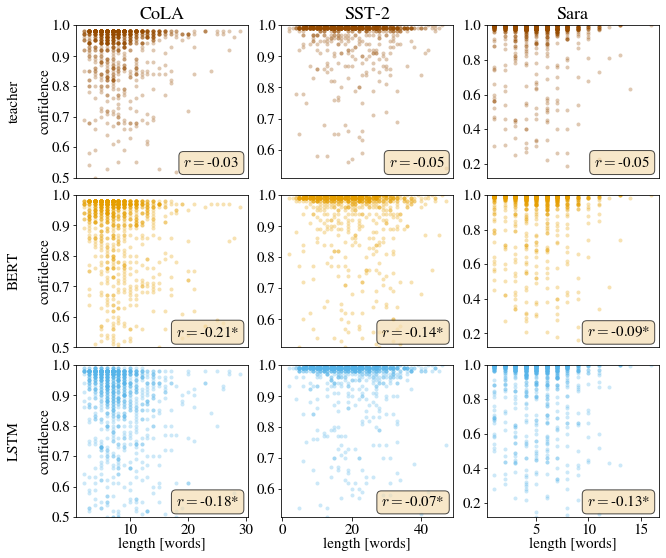

In [148]:
take_log = False
prob_log_limit = 0.99
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9.5, 8), sharex="col", sharey="col")
alpha = 0.3
for i, task in enumerate(glue_tasks):
    data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
    axs[0, i].set_title(task)
    for j, model_type in enumerate(model_types["main"]):
        ax = axs[j, i]
        ys = data["confidence_{}".format(model_type)]
        xs = data["sentence"].apply(lambda s: len(s.split()))
        R, p = pearsonr(xs, ys)
        text = "$r = ${:.2f}".format(R) + ("*" if p < 0.05 else "")
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        ax.text(0.95, 0.05, text, transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right', bbox=props)
        if take_log:
            ys = np.minimum(ys, prob_log_limit)
            ys = np.log(1-ys)*-1
        ax.plot(xs, ys, marker=".", color=[*model_colours[model_type], alpha], markeredgewidth=0, linewidth=0, markersize=8)
        bottom = min(ys)
        top = max(ys)
        ax.set_ylim(bottom, 1.0)
        if i == 0: ax.set_ylabel(model_type + "\n\nconfidence", labelpad=0)
        ax.tick_params(axis="y", pad=2)
        if j == 2: ax.set_xlabel("length [words]", labelpad=0) 
        else: ax.tick_params(axis="x", length=0)
        if take_log:
            ticks = [bottom, bottom + (-np.log(1-prob_log_limit) - bottom)/3, 
                     bottom + 2*(-np.log(1-prob_log_limit) - bottom)/3, -np.log(1-prob_log_limit)]
            ticklabels = ["{:.2f}".format(-np.exp(-t)+1) for t in ticks]
            ax.set_yticks(ticks)
            ax.set_yticklabels(ticklabels)
            
plt.tight_layout(w_pad=0.1, h_pad=0.8)
plt.show()

# Correlation between sentence length and correctness

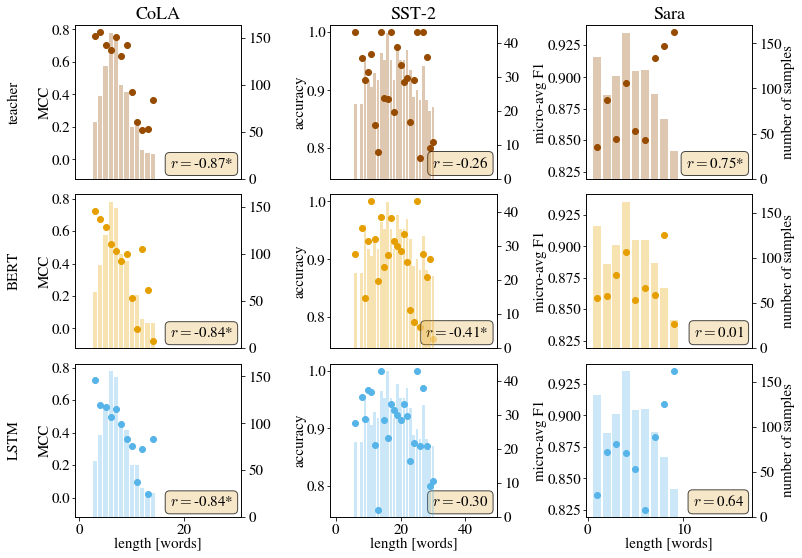

In [189]:
take_log = False
prob_log_limit = 0.99
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(11.5, 8), sharex="col", sharey="col")
alpha = 0.3
for i, task in enumerate(glue_tasks):
    data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
    lengths = data["sentence"].apply(lambda s: len(s.split()))
    data = data.assign(length=lengths)
    lengths = range(1, max(lengths)+1)
    axs[0, i].set_title(task)
    for j, model_type in enumerate(model_types["main"]):
        ax = axs[j, i]
        xs = lengths
        ys = []
        ys1 = []
        for l in lengths:
            rows = data[data["length"] == l]
            if len(rows) >= 20:
                score = compute_score(rows["label"], rows["pred_" + model_type], task)
                ys.append(score)
                ys1.append(len(rows))
            else:
                ys.append(None)
                ys1.append(0)
        R, p = pearsonr(np.array(xs)[np.array(ys) != None], np.array(ys)[np.array(ys) != None])
        text = "$r = ${:.2f}".format(R) + ("*" if p < 0.05 else "")
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        ax.text(0.95, 0.05, text, transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right', bbox=props)
        ax.plot(xs, ys, marker=".", color=model_colours[model_type], linewidth=0, markersize=12)
        ax2 = ax.twinx()
        ax2.bar(xs, ys1, color=[*model_colours[model_type], alpha])
        if i == 0: 
            ax.set_ylabel(model_type + "\n\n{}".format(metrics[task]), labelpad=0)
        else:
            ax.set_ylabel("{}".format(metrics[task]), labelpad=0)
        if i == 2:
            ax2.set_ylabel("number of samples", labelpad=0)
        ax.tick_params(axis="y", pad=1)
        if j == 2: ax.set_xlabel("length [words]", labelpad=0) 
        else: ax.tick_params(axis="x", length=0)
plt.tight_layout(w_pad=1.5, h_pad=0.5)
plt.show()